In [47]:
# mount gdrive and unzip data
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sys
workingdir = '/content/gdrive/My Drive/Colab Notebooks/EVA4/Session11'
sys.path.append(workingdir)

In [0]:
%matplotlib inline
import torch
import torchvision
import numpy as np
from utils import datapreparation
from utils import display
from model import dnn
from model import resnet
from utils import training
from utils import evaluate
from utils import lrfinder
from utils import lr_rangetest
from utils import onecyclelr
from utils import gradcam 
from utils import gradvisualize

# DRAWING GRAPH

In [0]:
from utils import graph

In [51]:
classes, trainloader, testloader = datapreparation.load(albumentations=True)

Files already downloaded and verified
Files already downloaded and verified
CUDA Available? True


shape: torch.Size([512, 3, 32, 32])


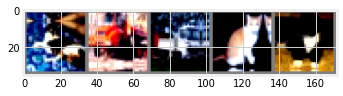

  cat truck truck   cat   cat


In [52]:
display.show_random_images(trainloader, classes, 5)

In [53]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
net = resnet.CustomResNet11()
model = net.to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
CustomResnetBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         294,912
        MaxPool2d-14            [-

/content/gdrive/My Drive/Colab Notebooks/EVA4/Session11/model/resnet.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)


# Finding best lr and using it for maximum learning rate

/content/gdrive/My Drive/Colab Notebooks/EVA4/Session11/model/resnet.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)



Learning rate search finished. See the graph with {finder_name}.plot()


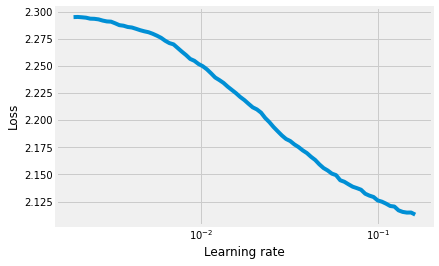

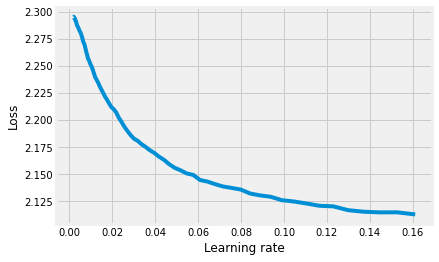

In [54]:
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-3, momentum=0.9)
lr = lrfinder.LRFinder(model, optimizer, criterion, device="cuda")
lr.range_test(trainloader, end_lr=0.20, num_iter=len(trainloader), step_mode="exp")
lr.plot(log_lr=True)
lr.plot(log_lr=False)
lr.reset()

# At lr = 0.025, we can see the loss is getting decreases rapidly..


In [0]:
max_lr = 0.025

# When min_lr = max_lr / 5, maximum accuracy is 87.41
# When min_lr = max_lr / 6, maximum accuracy is 87.6
# When min_lr = max_lr / 7, maximum accuracy is 87.7
# When min_lr = max_lr / 8, maximum accuracy is 88.1
# When min_lr = max_lr / 9, maximum accuracy is 87.6
# When min_lr = max_lr / 10, maximum accuracy is 87.6

In [56]:
min_lr = max_lr / 10
print(min_lr)

0.0025


In [57]:
initial_lr = 0.001


EPOCHS = 24
steps_per_epoch = len(trainloader)
num_steps = steps_per_epoch * EPOCHS
peak_lr_epoch = 5 
pct_start = float (peak_lr_epoch/EPOCHS)
div_factor = float (max_lr/initial_lr)
final_div_factor = float (initial_lr/min_lr)

print("maxlr: ", max_lr)
print("min_lr: ", min_lr)
print("initial_lr: ", initial_lr)
print("epochs: ", EPOCHS)
print("steps_per_epoch: ", steps_per_epoch)
print("pct_start: ", pct_start)
print("div_factor: ", div_factor)
print("final_div_factor: ", final_div_factor)

optimizer = optim.SGD(model.parameters(), lr=max_lr, momentum=0.9)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr, 
                                                epochs=EPOCHS, 
                                                steps_per_epoch=steps_per_epoch, 
                                                pct_start=pct_start, 
                                                anneal_strategy='cos', 
                                                cycle_momentum=True, 
                                                base_momentum=0.85, 
                                                max_momentum=0.95, 
                                                div_factor=div_factor, 
                                                final_div_factor=final_div_factor, 
                                                last_epoch=-1)

maxlr:  0.025
min_lr:  0.0025
initial_lr:  0.001
epochs:  24
steps_per_epoch:  98
pct_start:  0.20833333333333334
div_factor:  25.0
final_div_factor:  0.4


In [58]:
misclassified_imgs = []
correct_imgs = []
lrs = []
for epoch in range(EPOCHS):
    print("EPOCH:", epoch+1)
    print("Starting Learning Rate:", scheduler.get_lr())
    lrs = training.train_model(model, device, trainloader, optimizer, scheduler, criterion, epoch)
    misclassified_imgs, correct_imgs = training.test_model(model, device, criterion, testloader, epoch==EPOCHS-1)

/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:1206: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)
  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH: 1
Starting Learning Rate: [0.0010000000000000009]


/content/gdrive/My Drive/Colab Notebooks/EVA4/Session11/model/resnet.py:163: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  out = F.softmax(out)
Loss=2.1421453952789307 Batch_id=97 Accuracy=22.65: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0043, Accuracy: 3436/10000 (34.36%)

EPOCH: 2
Starting Learning Rate: [0.0033008670573439515]


Loss=2.065505027770996 Batch_id=97 Accuracy=37.58: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0041, Accuracy: 3953/10000 (39.53%)

EPOCH: 3
Starting Learning Rate: [0.009321136693447377]


Loss=2.0286753177642822 Batch_id=97 Accuracy=45.14: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0040, Accuracy: 4630/10000 (46.30%)

EPOCH: 4
Starting Learning Rate: [0.016752168894637195]


Loss=1.8444831371307373 Batch_id=97 Accuracy=53.44: 100%|██████████| 98/98 [00:32<00:00,  2.97it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0038, Accuracy: 5799/10000 (57.99%)

EPOCH: 5
Starting Learning Rate: [0.022744327461950115]


Loss=1.7659131288528442 Batch_id=97 Accuracy=66.74: 100%|██████████| 98/98 [00:32<00:00,  2.98it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0036, Accuracy: 6464/10000 (64.64%)

EPOCH: 6
Starting Learning Rate: [0.024999983987364575]


Loss=1.7224394083023071 Batch_id=97 Accuracy=72.38: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7508/10000 (75.08%)

EPOCH: 7
Starting Learning Rate: [0.024843424674492617]


Loss=1.7512624263763428 Batch_id=97 Accuracy=75.45: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7498/10000 (74.98%)

EPOCH: 8
Starting Learning Rate: [0.024384265654900344]


Loss=1.6846987009048462 Batch_id=97 Accuracy=77.70: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7796/10000 (77.96%)

EPOCH: 9
Starting Learning Rate: [0.023635031589704005]


Loss=1.6747232675552368 Batch_id=97 Accuracy=79.60: 100%|██████████| 98/98 [00:32<00:00,  3.06it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0034, Accuracy: 7567/10000 (75.67%)

EPOCH: 10
Starting Learning Rate: [0.022616159631094705]


Loss=1.6523867845535278 Batch_id=97 Accuracy=80.46: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8035/10000 (80.35%)

EPOCH: 11
Starting Learning Rate: [0.021355441950102343]


Loss=1.6438876390457153 Batch_id=97 Accuracy=82.31: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8009/10000 (80.09%)

EPOCH: 12
Starting Learning Rate: [0.019887267638618672]


Loss=1.6557035446166992 Batch_id=97 Accuracy=83.13: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8210/10000 (82.10%)

EPOCH: 13
Starting Learning Rate: [0.018251684664616182]


Loss=1.6248047351837158 Batch_id=97 Accuracy=84.24: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8194/10000 (81.94%)

EPOCH: 14
Starting Learning Rate: [0.016493307467979057]


Loss=1.6059468984603882 Batch_id=97 Accuracy=85.23: 100%|██████████| 98/98 [00:32<00:00,  3.04it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8358/10000 (83.58%)

EPOCH: 15
Starting Learning Rate: [0.014660099994884311]


Loss=1.5802768468856812 Batch_id=97 Accuracy=85.99: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8279/10000 (82.79%)

EPOCH: 16
Starting Learning Rate: [0.01280206736638274]


Loss=1.5822889804840088 Batch_id=97 Accuracy=86.61: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0033, Accuracy: 8310/10000 (83.10%)

EPOCH: 17
Starting Learning Rate: [0.0109698918690503]


Loss=1.5568768978118896 Batch_id=97 Accuracy=87.47: 100%|██████████| 98/98 [00:32<00:00,  2.99it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8567/10000 (85.67%)

EPOCH: 18
Starting Learning Rate: [0.009213550474329148]


Loss=1.5775384902954102 Batch_id=97 Accuracy=88.20: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8586/10000 (85.86%)

EPOCH: 19
Starting Learning Rate: [0.0075809515970269754]


Loss=1.583850622177124 Batch_id=97 Accuracy=88.90: 100%|██████████| 98/98 [00:32<00:00,  3.02it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8594/10000 (85.94%)

EPOCH: 20
Starting Learning Rate: [0.0061166282786489475]


Loss=1.5636743307113647 Batch_id=97 Accuracy=89.39: 100%|██████████| 98/98 [00:32<00:00,  3.00it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8697/10000 (86.97%)

EPOCH: 21
Starting Learning Rate: [0.004860523442114404]


Loss=1.552393913269043 Batch_id=97 Accuracy=90.12: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8708/10000 (87.08%)

EPOCH: 22
Starting Learning Rate: [0.003846900352943092]


Loss=1.5590310096740723 Batch_id=97 Accuracy=90.59: 100%|██████████| 98/98 [00:32<00:00,  3.01it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8694/10000 (86.94%)

EPOCH: 23
Starting Learning Rate: [0.0031034080066894105]


Loss=1.559554100036621 Batch_id=97 Accuracy=90.97: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.0032, Accuracy: 8711/10000 (87.11%)

EPOCH: 24
Starting Learning Rate: [0.002650326936419267]


Loss=1.5494260787963867 Batch_id=97 Accuracy=91.27: 100%|██████████| 98/98 [00:32<00:00,  3.03it/s]



Test set: Average loss: 0.0032, Accuracy: 8762/10000 (87.62%)

